In [1]:
# Lets import required modules

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
!wget https://www.dropbox.com/s/fxn3ldztzwxm0rw/FruitsData.zip

--2023-03-15 03:52:50--  https://www.dropbox.com/s/fxn3ldztzwxm0rw/FruitsData.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fxn3ldztzwxm0rw/FruitsData.zip [following]
--2023-03-15 03:52:51--  https://www.dropbox.com/s/raw/fxn3ldztzwxm0rw/FruitsData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a5b4a7f189907a48d96386b44.dl.dropboxusercontent.com/cd/0/inline/B4TzLSiosriztfRtvnyqAAvnArSBJ2CBX7OwZQyXWLEHmH3yPM3AQvcyJpFS9F4Gc4lbcZFEoPkpk6WOWrOTL4Zzru2LENrbrYzbjByB302k87ws9YuqmA9rk5h6ACsl78ExOf2wbYzkNcv-FM8hjeEYKPIDRZ1I2akkkkgOvcqGRA/file# [following]
--2023-03-15 03:52:51--  https://uc4a5b4a7f189907a48d96386b44.dl.dropboxusercontent.com/cd/0/inline/B4TzLSiosriztfRtvnyqAAvnArSBJ2CBX7OwZQyXWLEHmH3yPM3AQvcyJpFS9F4Gc4lbcZFE

In [3]:
!unzip -q "/content/FruitsData.zip"

In [4]:
# Getting the list of all the image path in string format

train_data = Path("fruits-360/Training")
train_data_path = train_data.glob("*/*")
train_data_path = list(train_data_path)
train_image_path = list(map(lambda x: str(x), train_data_path))

In [5]:
train_image_path[0:5]

['fruits-360/Training/Blueberry/r_297_100.jpg',
 'fruits-360/Training/Blueberry/268_100.jpg',
 'fruits-360/Training/Blueberry/155_100.jpg',
 'fruits-360/Training/Blueberry/68_100.jpg',
 'fruits-360/Training/Blueberry/r_128_100.jpg']

In [6]:
# lets create a target variable from the image path since its mantioned there

def labelizer(train_data):
    return list(map(lambda x: x.split("/")[-2], train_data))

In [7]:
train_image_labels = labelizer(train_image_path)

In [8]:
# We will need to convert categorical data types into labels s that machine can understand the input


from sklearn.preprocessing import LabelEncoder 
Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

# We have got the label encoded categories, but the model output will be a vector, so we will need to 
# convert encoded labes into vector, just ike one hot encoded format

train_image_labels = tf.keras.utils.to_categorical(train_image_labels)


In [9]:
train_image_labels[1001]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [10]:
# We are not provided with the validation data,
# hence we will need to extract validation data from the given input data

from sklearn.model_selection import train_test_split 

Train_paths , Validation_paths , Train_labels , Validation_labels = train_test_split(train_image_path , train_image_labels)

In [11]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3) 
    return image , label

In [12]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 224 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [13]:
# Function used to Create a Tensorflow Data Object

AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label), num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [14]:
# Creating Train Dataset object and Verifying it
train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(32, 224, 224, 3)
(32, 131)


Cocos


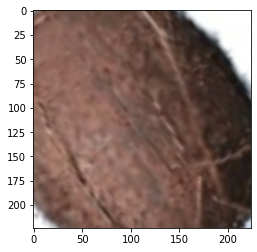

In [15]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[21])
plt.imshow((image[21].numpy()/255).reshape(224 , 224 , 3))

In [16]:
validation_dataset = get_dataset(Validation_paths , Validation_labels , train = False)

image , label = next(iter(validation_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 131)


Passion Fruit


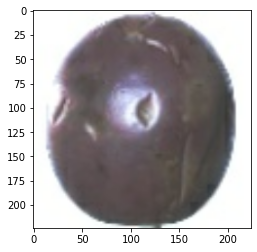

In [17]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[6])
plt.imshow((image[6].numpy()/255).reshape(224 , 224 , 3))

In [18]:
# Building EfficientNetB3 model
from tensorflow.keras.applications import EfficientNetB3

backbone = EfficientNetB3(input_shape=(224, 224, 3),include_top=False)

model = tf.keras.Sequential()

model.add(EfficientNetB3(input_shape=(224, 224, 3),include_top=False))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(131, activation='softmax'))


model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dense_1 (Dense)             (None, 131)               16899     
                                                                 
Total params: 10,997,170
Trainable params: 10,909,867
N

In [19]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [20]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=1,
    validation_data=validation_dataset,
    validation_steps = len(Validation_paths)//BATCH_SIZE,
)

1586/1586 [==============================] - 1138s 674ms/step - loss: 0.3615 - accuracy: 0.9076 - precision: 0.9530 - recall: 0.8794 - val_loss: 1.6204 - val_accuracy: 0.6277 - val_precision: 0.6800 - val_recall: 0.5833


In [21]:
model.layers[0].trainable = False

In [22]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dense_1 (Dense)             (None, 131)               16899     
                                                                 
Total params: 10,997,170
Trainable params: 213,635
Non-trainable params: 10,783,535
____________________________________

In [24]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=validation_dataset,
    validation_steps = len(Validation_paths)//BATCH_SIZE,
)

Epoch 1/8
1586/1586 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9750 - precision: 0.9790 - recall: 0.9719
Epoch 1: val_loss improved from inf to 0.69952, saving model to best_weights.h5
1586/1586 [==============================] - 1046s 659ms/step - loss: 0.0861 - accuracy: 0.9750 - precision: 0.9790 - recall: 0.9719 - val_loss: 0.6995 - val_accuracy: 0.8134 - val_precision: 0.8434 - val_recall: 0.7926
Epoch 2/8
1586/1586 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9819 - precision: 0.9843 - recall: 0.9803
Epoch 2: val_loss did not improve from 0.69952
1586/1586 [==============================] - 1041s 657ms/step - loss: 0.0630 - accuracy: 0.9819 - precision: 0.9843 - recall: 0.9803 - val_loss: 0.8184 - val_accuracy: 0.7917 - val_precision: 0.8247 - val_recall: 0.7731
Epoch 3/8
1586/1586 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9842 - precision: 0.9856 - recall: 0.9830
Epoch 3: val_loss did not impro

In [25]:
def get_dataset_test(paths , labels):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [26]:
def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="bilinear")
    return image , label

In [29]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation


test_path = Path("fruits-360/Test")
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))

test_image_labels = labelizer(test_image_paths)
test_labels = Le.transform(test_image_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

test_image_paths = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

dataset = tf.data.Dataset.zip((test_image_paths , test_labels))

dataset = dataset.map(lambda image, label: decode_image(image, label))
test_dataset = dataset.batch(BATCH_SIZE)


In [30]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 131)


Blueberry


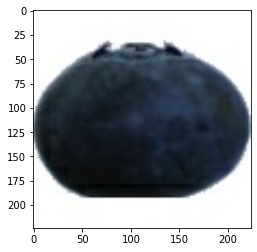

In [31]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [32]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

709/709 [==============================] - 77s 109ms/step - loss: 1.7613 - accuracy: 0.7009 - precision: 0.7221 - recall: 0.6868
 Testing Acc :  0.7009432315826416
 Testing Precision  0.7220703363418579
 Testing Recall  0.6868388652801514


In [33]:
def LoadImage(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="bilinear")
    plt.imshow(image.numpy()/255)
    image = tf.expand_dims(image , 0)
    return image

def RealtimePrediction(image_path , model, encoder_):
    image = LoadImage(image_path)
    prediction = model.predict(image)
    prediction = np.argmax(prediction , axis = 1)
    return encoder_.inverse_transform(prediction)[0]

1/1 [==============================] - 3s 3s/step


'Apple Braeburn'

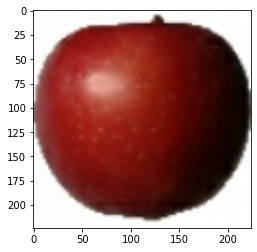

In [34]:
RealtimePrediction("/content/fruits-360/Training/Apple Braeburn/100_100.jpg" , model , Le)